## MasterProject SoSe22: "Non-Intrusive Load Monitoring" (NILM)

### Related Work and Backgrounds

- Use publicly available data sets **RAE**, as described by [Makonin et al., 2019] in their paper "RAE: The Rainforest Automation Energy Dataset for Smart Grid Meter Data Analysis".
- Follow general NILM problem description, outlined by [Marwah and Han, 2011] in their paper "Unsupervised Disaggregation of Low Frequency Power Measurements".
- A nice overview of various state-of-the-art techniques used for NILM is found in [Herrero et al., 2018] paper "Non Intrusive Load Monitoring (NILM):A State of the Art", including LSTM models.
- [Herrero et al., 2018] references a PhD Thesis [Kelly, 2017] on "Disaggregation of domestic smart meter energy data": Find in Section 9.4.3 a detailed description of a CNN model.

### Game Plan

#### Data

Decided to work on **RAE data set**. That provides total power consumption and submeter data for two houses. Pick the **first house** in this work and find **24 submeters** and **two sampling periods** of 9 and 63 days, respectively. **Sampling rate is 1Hz**. 

**Idea:** Could use 63 days sample for training before testing the model on the second sample covering 9 days.

#### Problem Statement

Given an aggregate power consumption $Y$ for a total of $T$ time periods:

$$Y = (y_1, y_2,..,y_T)$$

We then want to infer the power load of each of the $M$ appliances for all time steps:

$$ Q^{(1)} = (q^{(1)}_1, q^{(1)}_2,..,q^{(1)}_T) \\
   Q^{(2)} = (q^{(2)}_1, q^{(2)}_2,..,q^{(2)}_T) \\
   ... \\
   Q^{(M)} = (q^{(M)}_1, q^{(M)}_2,..,q^{(M)}_T)
$$

#### Model

There exist various approaches for dissagregation of total power consumption. Here we focus on **deep ANN models** from the domain of **supervised machine learning** techniques. The idea is as follows:

- Feed a sample consisting of a number of time steps of the total power consumption time series as input.
- We use a **sliding window approach** and the appropriate **input length** needs to be specified.
- Later we could extend the model and feed time of the day and/or day of the week as **additional input features**.
- As **target** we have **three scalar values** for each of the $M$ submeters. **Note:** We might not use all submeters or further aggregate certain submeters!
- These three scalar values are **start time, end time and average power consumption for a given submeter** (or aggregate submeters). **Note:** We only predict the *first* usage in the given sample. Details on scaling these three features can be found in Section 9.4.3 of [Kelly, 2017].
- Most promising appears a **CNN/fc model** consisting of one or more CNN layers followd by one or more fully connected (fc) layers with 3 output units. Further details on model setup can also be found in Section 9.4.3 of [Kelly, 2017].
- We then have one (sub-)model for each submeter. Could also try to predict 3 output values for *all* $M$ submeters simultaneously - using $3 \times M$ output units.

#### Data Inspection and Pre-Processing

- **Download data** of both sampling periods for house1 from cloud storage.

For our example house we know not only the aggregate power consumption $Y$ but also power load of each of the $M$ appliances $Q^{(1)},Q^{(2)},..,Q^{(M)}$.

- Create **histogram of appliances' power consumption and ON-durations** as in Figures 2 and 3 of [Marwah and Han, 2011]. 

Expect to find some narrow Gaussian distribution for appliances' power consumption. We could then use mean power consumption for each appliance as a given "steady state feature" and only model ON-durations. However, we will try to predict average power consumption as well, as explained above.

The histogram of ON-durations gives us a feeling for an appropriate input length in our sliding window approach, also explained above.

- Add "time of day" and "day of week" as "non traditional features" from given unix timestamp (= sec passed since Jan 1st, 1970, 00:00h UTC).

Most important pre-processing step is **labelling the submeter time series**:

- Split power load of each of the $M$ appliances into sequences of specified input length.
- Get start time, end time and average power consumption for a given submeter in every sample, scale to [0,1]. **Note:** Only encounter *first* usage in sample, ignore further usages! If submeter is *not* used in sample, all three values are *zero*.

### Tech Preamble

In [1]:
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, MaxPooling1D, Dropout, Flatten, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as tfds
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

### Load and inspect Data

In [2]:
## Read input files:

# Have TWO continuous samples covering 9 (data1) and 63 days (data2), respectively.

# Skip header and keep ALL columns: Unix timestamp, some interval total values,
# total power consumption ('main') followed by 24 submeters ('sub1' .. 'sub24').

# Define path to data folder:
path_to_data = "../data"

# Import data from csv files:
data1 = np.genfromtxt(join(path_to_data,'house1_power_blk1.csv'), delimiter=',', skip_header=1)
#data2 = np.genfromtxt(join(path_to_data,'house1_power_blk2.csv'), delimiter=',', skip_header=1)
data2 = data1 # to save time, when only working with data1

In [3]:
# Check dimensions:
print("data1 shape (samples, features): ", data1.shape)
print("data2 shape (samples, features): ", data2.shape)
print("\ndata1 contains ", np.round(data1.shape[0]/ (24*3600),2), " days")
print("data2 contains ", np.round(data2.shape[0]/ (24*3600),2), " days")

data1 shape (samples, features):  (777600, 27)
data2 shape (samples, features):  (777600, 27)

data1 contains  9.0  days
data2 contains  9.0  days


In [4]:
# Check for NaN values in data (main and submeters, only):
print("NaN values in data1: ",np.sum(np.isnan(data1[:,2:])))
print("NaN values in data2: ",np.sum(np.isnan(data2[:,2:])))
print("\nNaN values for main and submeters in data2: \n", np.sum(np.isnan(data2[:,2:]), axis=0)) # 21 sec missing data

NaN values in data1:  0
NaN values in data2:  0

NaN values for main and submeters in data2: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [5]:
# Replace NaN values in data2 by zero:
(data2[:,2:])[np.isnan(data2[:,2:])]=0

In [6]:
## Create labels for 24 submeters in house 1 (copy from house1_labels.txt)

# Numbers of submeters:
labels_num = np.arange(1,25,1)

# Text labels:
labels_long = ['Kitchen Wall Oven L1','Kitchen Wall Oven L2','Kitchen Counter Plugs L1','Kitchen Counter Plugs L2',
               'Clothes Dryer L1','Clothes Dryer L2','Upstairs Bedroom AFCI Arc-Fault Plugs','Kitchen Fridge',
               'Clothes Washer','Kitchen Dishwasher','Furnace & Hot Water Unit (incl. Furnace Room Plug)',
               'Basement Plugs & Lights (incl. Outside Plugs)','Heat Pump L1','Heat Pump L2','Garage Sub-Panel L1',
               'Garage Sub-Panel L2','Upstairs Plugs & Lights L1 (incl. Bathroom Lights and Vent Fan, Smoke Alarms, Living Room Plugs)',
               'Upstairs Plugs & Lights L2 (incl. Bathroom Lights and Vent Fan, Smoke Alarms, Living Room Plugs)',
               'Basement Blue Plugs (incl. Ent. TV/Amp/DVD/PVR)','Bathrooms (incl. 3 GFCI Plugs, 2 Lights, 1 Vent Fan, Chest Freezer)',
               'Rental Suite Sub-Panel L1','Rental Suite Sub-Panel L2','Misc. Plugs (incl. Dining Room, Gas Cooktop, Microwave)',
               'Home Office (incl. Telco/Cable/Net/Security Equip.)']

In [7]:
## Try to reproduce plot of all loads for one day for house 1, as in [Makonin et al., 2019]:
## Note: stackplot needs transposed data!

# Create time axis for one day:
time = range(24*3600)

# Transpose submeter data, need to skip first three columns (Unix timestamp, some interval total values,
# total power consumption ('main')):
data1_transp = np.transpose(data1[:,3:])
data2_transp = np.transpose(data2[:,3:])

# Extract first day from first sample (covering 9 days in total):
data1_transp_d1 = data1_transp[:,:24*3600]

In [8]:
## Further aggregate submeters to end up with 10 classes:

# Initialize storage for aggregate transposed submeter data:
data1_transp_agg = np.zeros((10,len(data1)))
data2_transp_agg = np.zeros((10,len(data2)))

## Manually aggragate submeters, as in [Makonin et al. 2019]:

# Garage: Submeters 15, 16
data1_transp_agg[0] = data1_transp[14] + data1_transp[15]
data2_transp_agg[0] = data2_transp[14] + data2_transp[15]

# Clothes Dryer: Submeters 5, 6
data1_transp_agg[1] = data1_transp[4] + data1_transp[5]
data2_transp_agg[1] = data2_transp[4] + data2_transp[5]

# HVAC & Heat Pump: Submeters 11, 13, 14
data1_transp_agg[2] = data1_transp[10] + data1_transp[12] + data1_transp[13]
data2_transp_agg[2] = data2_transp[10] + data2_transp[12] + data2_transp[13]

# Rental Suite: Submeters 21, 22
data1_transp_agg[3] = data1_transp[20] + data1_transp[21]
data2_transp_agg[3] = data2_transp[20] + data2_transp[21]

# Plugs & Lights: Submeters 3, 4, 7, 12, 17, 18, 19, 20, 23
data1_transp_agg[4] = data1_transp[2] + data1_transp[3] + data1_transp[6] + data1_transp[11] + data1_transp[16] + data1_transp[17] + data1_transp[18] + data1_transp[19] + data1_transp[22]
data2_transp_agg[4] = data2_transp[2] + data2_transp[3] + data2_transp[6] + data2_transp[11] + data2_transp[16] + data2_transp[17] + data2_transp[18] + data2_transp[19] + data2_transp[22]

# Wall Oven: Submeters 1, 2
data1_transp_agg[5] = data1_transp[0] + data1_transp[1]
data2_transp_agg[5] = data2_transp[0] + data2_transp[1]

# Fridge: Submeter 8
data1_transp_agg[6] = data1_transp[7]
data2_transp_agg[6] = data2_transp[7]

# Clothes Washer: Submeter 9
data1_transp_agg[7] = data1_transp[8]
data2_transp_agg[7] = data2_transp[8]

# Dish Washer: Submeter 10
data1_transp_agg[8] = data1_transp[9]
data2_transp_agg[8] = data2_transp[9]

# Home Office: Submeter 24
data1_transp_agg[9] = data1_transp[23]
data2_transp_agg[9] = data2_transp[23]

## Create labels for aggregate submeters:
labels_long_agg = ['Garage','Clothes Dryer','HVAC & Heat Pump','Rental Suite','Plugs & Lights','Wall Oven',
                   'Fridge','Clothes Washer','Dish Washer','Home Office']

In [9]:
# Plausibility Check: Sum of aggregated submeters must equal total energy consumption in raw data. 
# Expect zero difference!
print("plausi check sample 1 (expect 0.0): ", np.sum(np.sum(data1_transp_agg,axis=0)-data1[:,2]))
print("plausi check sample 2 (expect 0.0): ", np.sum(np.sum(data2_transp_agg,axis=0)-data2[:,2]))

plausi check sample 1 (expect 0.0):  0.0
plausi check sample 2 (expect 0.0):  0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

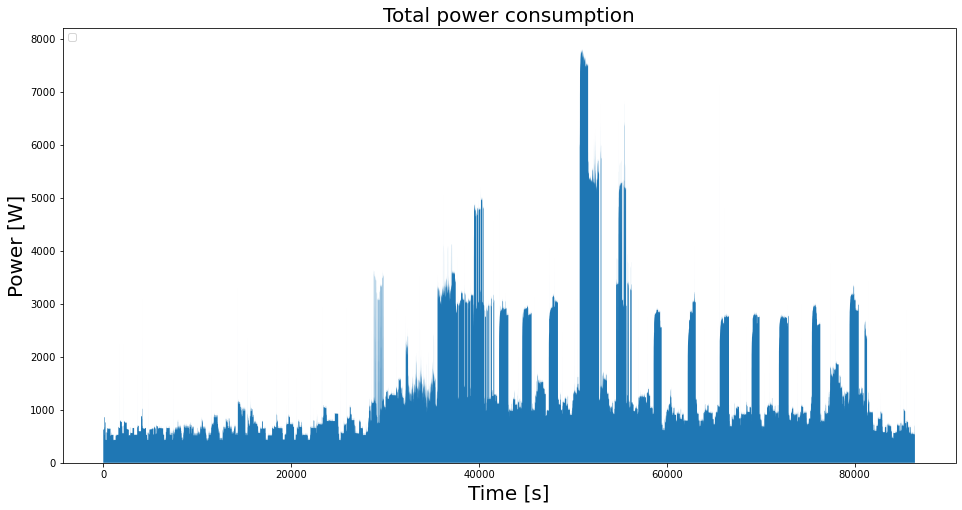

In [10]:
# Plot total power consumption from aggregate submeter data for first day from first sample:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(time, np.sum(data1_transp_agg,axis=0)[:24*3600])
plt.legend(loc='upper left')
plt.title('Total power consumption', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

Text(0, 0.5, 'Power [W]')

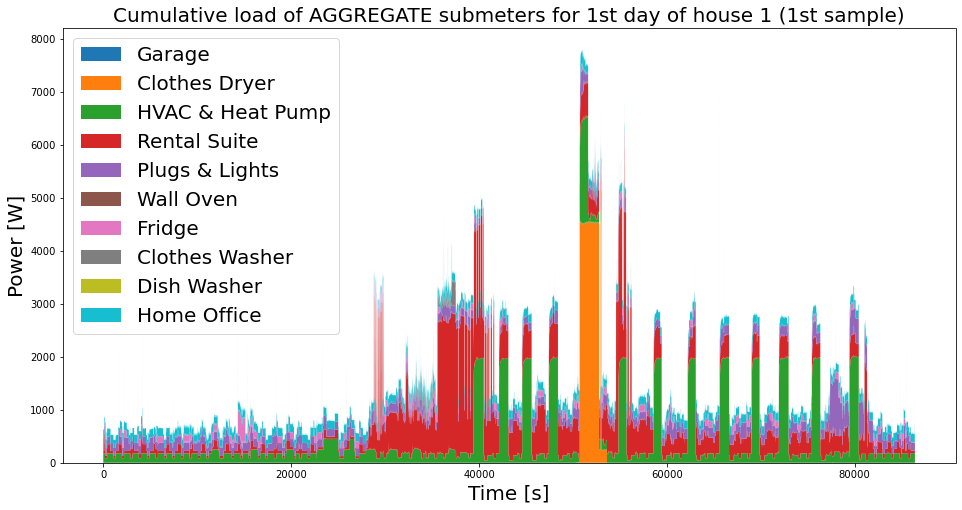

In [11]:
# Plot aggregate submeter data for first day from first sample:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(time, data1_transp_agg[:,:24*3600], labels=labels_long_agg)
plt.legend(loc='upper left', fontsize=20)
plt.title('Cumulative load of AGGREGATE submeters for 1st day of house 1 (1st sample)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

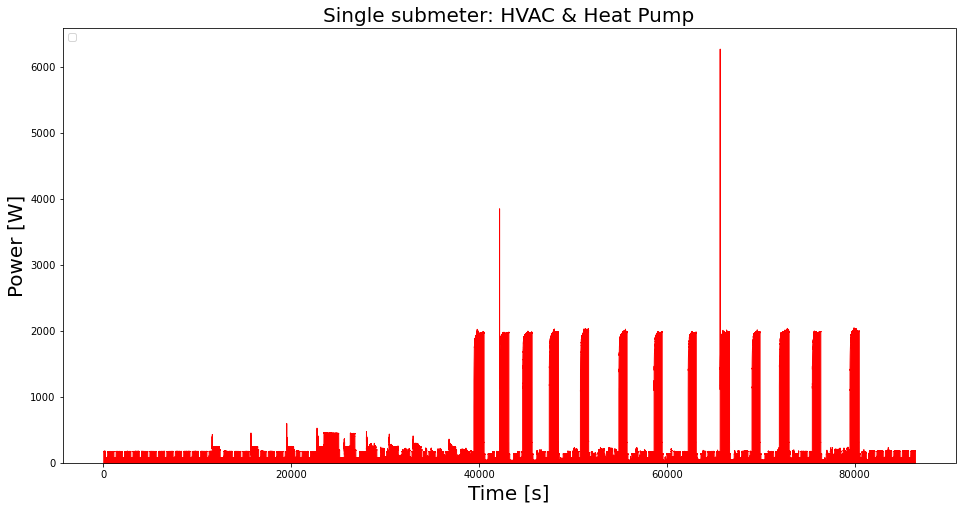

In [12]:
# Plot "HVAC & Heat Pump" from aggregated submeter data for first day from first sample:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(time, data1_transp_agg[2,:24*3600], color="red")
plt.legend(loc='upper left')
plt.title('Single submeter: HVAC & Heat Pump', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

Text(0, 0.5, 'Power [W]')

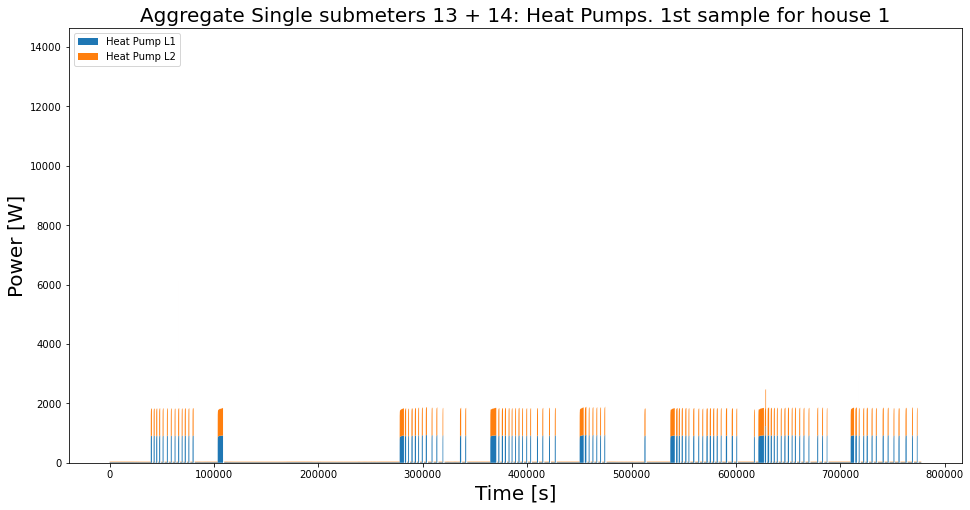

In [13]:
# Aggregate power load for Heat Pumps: Whole time span of first sample (9 days) for house1    
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(data1_transp.shape[1]), data1_transp[12:14,:], labels=labels_long[12:14])
plt.legend(loc='upper left')
plt.title('Aggregate Single submeters 13 + 14: Heat Pumps. 1st sample for house 1', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

In [14]:
## Decision after inspection:

## Continue only with following submeters:
# 4 Kitchen Counter Plugs L2: Seem to have nice noise-less pattern.
# 5 + 6 Clothes dryer L1 + L2: Could be aggregated, have similar ON/OFF times pattern.
# 8 Fridge: Needed to zoom in to see nice pattern on shorter time scales, compared to e.g. dishwasher
# 9 Clothes washer
# 10 Dish Washer
# 13 + 14 Heat Pumps: Could be aggregated, have similar ON/OFF times pattern.

## Ignore the rest for now: Either too noisy / irregular (plugs / home office), or avg. load close to zero or 
## in aggregated form (rental suite).
## But with above selection we should already cover quite some significant portion of total power load!

# And keep in mind: We still use the total power load signial including ALL submeters as input signal!

In [15]:
### NEXT: Start with aggregated Heat Pumps as Prototype

# Define noise level and delay time. 
# Get labels
# [Plot histogram of avg use during ON periods]
# [Plot histogram of ON durations]
# Derive reasonable input length T
# Split data
# Scale Start Time, End Time, Avg Power Load to [0,1]
# CNN / fc model
# Post-processing: Restore time series with predicted power load from predicted start/end times
# Performance Measures

In [16]:
## Extract input series for samples 1 and 2 from data: Total Power Load.
## Remember: Total Power Load is third column in data!
inputs1 = data1[:,2]
inputs2 = data2[:,2]

In [17]:
## Extract and aggregate target series for samples 1 and 2 from data: Heat pumps (subm 13 + 14).
## Remember: Submeters 13 + 14 are columns 16 + 17 in data
target1 = np.sum(data1[:,15:17], axis=1)
target2 = np.sum(data2[:,15:17], axis=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

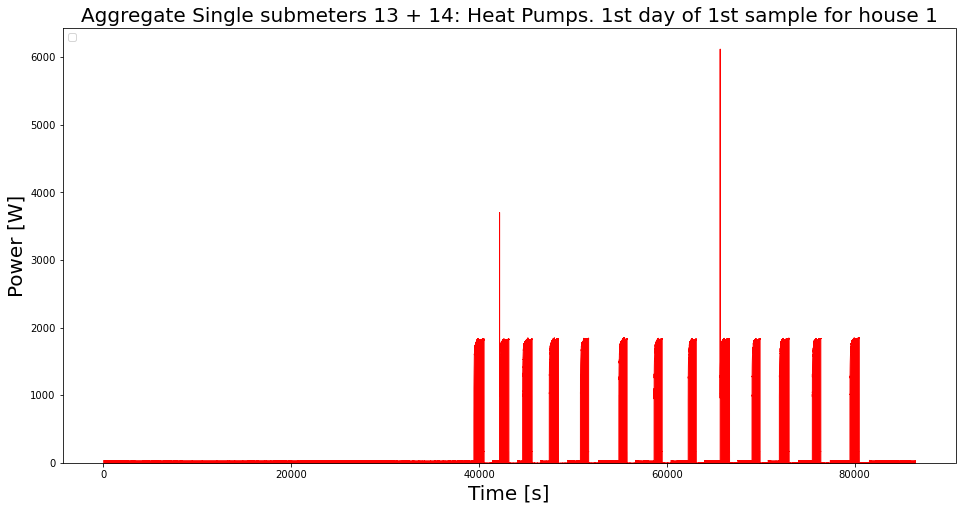

In [18]:
## Try to define noise level by visual inspection first:

# Plot Heat pumps in aggregated form from submeter data 13 + 14 for first day from first sample:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(time, target1[:24*3600], color="red")
plt.legend(loc='upper left')
plt.title('Aggregate Single submeters 13 + 14: Heat Pumps. 1st day of 1st sample for house 1', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

In [19]:
## Looks like constant "stand-by" power load during OFF times:
target1[:10]

array([38., 38., 38., 38., 38., 38., 38., 38., 38., 38.])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

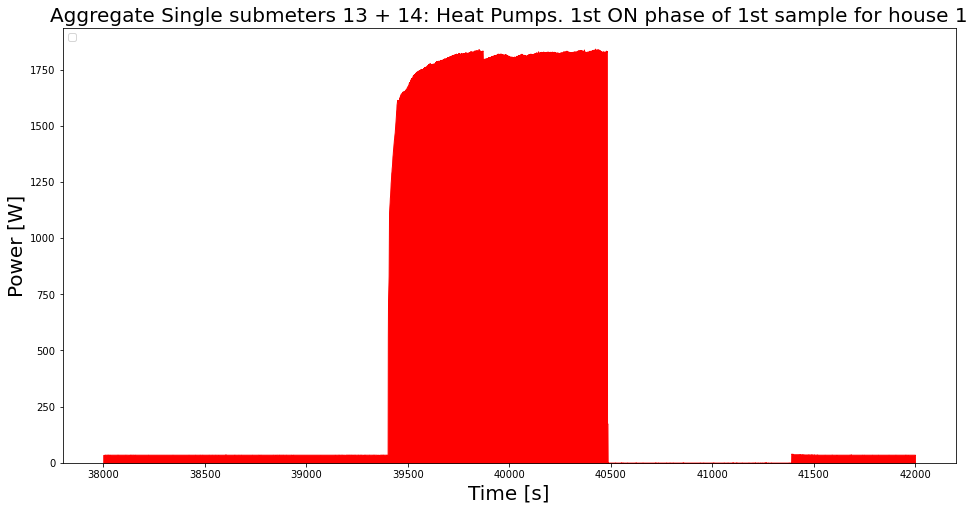

In [20]:
## Zoom into first ON phase, to see if power load unexpectedly drops to zero during ON phase:

# Plot Heat pumps in aggregated form from submeter data 13 + 14 for first usage from first sample:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(np.arange(38000,42000,1), target1[38000:42000], color="red")
plt.legend(loc='upper left')
plt.title('Aggregate Single submeters 13 + 14: Heat Pumps. 1st ON phase of 1st sample for house 1', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

In [21]:
## Set noise level and delay time.
## "Delay time" means, that power load is allowed to drop below noise level during ON phase for a specified
## number of seconds. If drop exceeds delay time, we assume the appliance to be switched OFF again.

# Noise level of 50 Watt seems to be sufficient, since "stand-by" load appears to be constantly at 38 Watt.
noise_level = 50

# There seem to be no unexpected drops in power load during ON phase. 
delay_time = 0

In [22]:
# Now create new binary series containing 1 (= ON) and 0 (= OFF), respecting specified noise level:
target1_ON_OFF = (target1 > noise_level).astype(int)

# Get power load during ON times:
target1_load = target1 * target1_ON_OFF

# Get mean power load from load during ON times as single value:
target1_mean_load = np.mean(target1_load[target1_load>0])

# Get mean load during ON times as time series:
target1_mean_load_series = target1_mean_load * target1_ON_OFF

# Check avg usage time and mean load during ON times:
print("avg usage: ", np.round(np.sum(target1_ON_OFF) / len(target1) * 100, 2), "%")
print("mean load during ON times: ", np.round(target1_mean_load,2), "W")

avg usage:  15.79 %
mean load during ON times:  1800.22 W


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

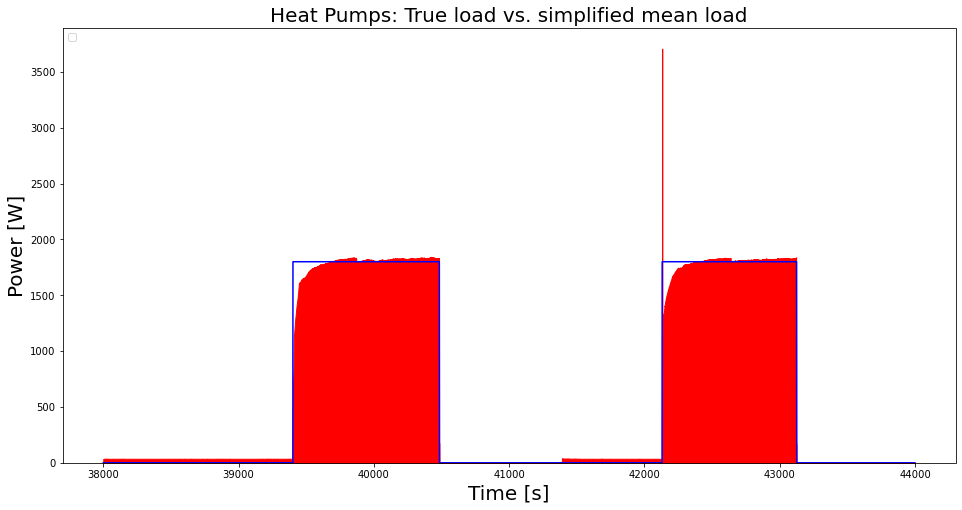

In [23]:
# Plot true load for heat pumps (aggregated) vs. simplified mean load for
# first two ON phases from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(np.arange(38000,44000,1), target1[38000:44000], color="red")
ax.plot(np.arange(38000,44000,1), target1_mean_load_series[38000:44000], color="blue")
plt.legend(loc='upper left')
plt.title('Heat Pumps: True load vs. simplified mean load', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

In [24]:
## Prepare labelling:

## Get switching events from binary ON_OFF series:
## Shift series by one time step and subtract original series.
## This gives us +1 for switchen ON and -1 for switching OFF.
target1_switch_events = target1_ON_OFF[1:] - target1_ON_OFF[:-1]

## But this requires adding a ZERO as first element, to keep dimensions correct:
target1_switch_events = np.insert(target1_switch_events,0,np.array([0]))

## Now get separate series for start and end times from switching event series:
target1_start_time = (target1_switch_events==1).astype(int)
target1_end_time = (target1_switch_events==-1).astype(int)

## Check dimensions and number of switching events:
print("switch events series shape (time steps): ", np.shape(target1_switch_events))
print("start_time series shape (time steps): ", np.shape(target1_start_time))
print("end_time series shape (time steps): ", np.shape(target1_end_time))
print("number of ON switch events: ", np.sum(target1_switch_events==1))
print("number of OFF switch events: ", np.sum(target1_switch_events==-1))
print("\ninputs1 shape (time steps, features): ", inputs1.shape)

switch events series shape (time steps):  (777600,)
start_time series shape (time steps):  (777600,)
end_time series shape (time steps):  (777600,)
number of ON switch events:  99
number of OFF switch events:  99

inputs1 shape (time steps, features):  (777600,)


In [26]:
# Get mean ON duration:
target1_ON_time = sum(target1_ON_OFF>0)
print("mean ON duration: ", np.round(target1_ON_time / np.sum(target1_switch_events==1),0), "sec")

mean ON duration:  1241.0 sec


In [27]:
# Define function to split time series 'sequence' into 'n_steps'
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

In [28]:
# Specify input length: Take a bit more than half of the mean ON duration
input_length = 200

# Split inputs and targets into sequences of specified length:
inputs1_split = split_sequence(inputs1, input_length)
target1_start_time_split = split_sequence(target1_start_time, input_length)
target1_end_time_split = split_sequence(target1_end_time, input_length)

# Check dimensions:
print("inputs1_split shape (samples, time steps, in features): ", np.shape(inputs1_split))
print("target1_start_time_split shape (samples, time steps, out features): ", np.shape(target1_start_time_split))
print("target1_end_time_split shape (samples, time steps, out features): ", np.shape(target1_end_time_split))

inputs1_split shape (samples, time steps, in features):  (777401, 200)
target1_start_time_split shape (samples, time steps, out features):  (777401, 200)
target1_end_time_split shape (samples, time steps, out features):  (777401, 200)


In [29]:
# Now have target samples as sequences, for both start time and end time.
# Need to convert to single target values, which shall be the position of the FIRST switching event (ON or OFF)
# relative to sequence length, hence a value in [0,1], where 0.5 refers to an event in the middle of input_length.
# If NO event is present in a sample, target value shall be ZERO.

# Initialize storage for target values: Position of start and end time
target1_start_time_pos = np.zeros((len(target1_start_time_split), 1))
target1_end_time_pos = np.zeros((len(target1_end_time_split), 1))

# Loop over target samples: Start time
for i in range(len(target1_start_time_split)):
    
    # Get current sample:
    sample = target1_start_time_split[i]
    
    # Look for non-zero values in current sample. Resulting shape is [1, num_of_occurences]. Use that in if clause:
    if np.array(np.nonzero(sample)).shape[1] > 0:
        
        # Store relative position of FIRST switching event:
        target1_start_time_pos[i] = (np.array(np.nonzero(sample))[0,0] + 1) / input_length
        
# Loop over target samples: End time
for i in range(len(target1_end_time_split)):
    
    # Get current sample:
    sample = target1_end_time_split[i]
    
    # Look for non-zero values in current sample. Resulting shape is [1, num_of_occurences]. Use that in if clause:
    if np.array(np.nonzero(sample)).shape[1] > 0:
        
        # Store relative position of FIRST switching event:
        target1_end_time_pos[i] = (np.array(np.nonzero(sample))[0,0] + 1) / input_length
        

In [30]:
# Reshape inputs (total power load) to have feature as third dimension:
inputs1_split_reshape = np.reshape(inputs1_split, (len(inputs1_split), input_length, 1))

# Concatenate targets: Position of start and end time
targets1_concat = np.concatenate([target1_start_time_pos, target1_end_time_pos], axis=1)

# Check dimensions:
print("inputs1_split_reshape shape (samples, time steps, in features): ", inputs1_split_reshape.shape)
print("targets1_concat shape (samples, out features): ", targets1_concat.shape)

inputs1_split_reshape shape (samples, time steps, in features):  (777401, 200, 1)
targets1_concat shape (samples, out features):  (777401, 2)


In [31]:
## Scale inputs (total power load) to [0,1] with min-max scaling:

# Get min / max:
input1_min = np.min(inputs1_split_reshape)
input1_max = np.max(inputs1_split_reshape)

# Scale:
inputs1_split_reshape_scaled = (inputs1_split_reshape - input1_min) / (input1_max - input1_min)

# Check scaling:
print("min BEFORE scaling: ", input1_min)
print("max BEFORE scaling: ", input1_max)
print("\nmin AFTER scaling: ", np.min(inputs1_split_reshape_scaled))
print("max AFTER scaling: ", np.max(inputs1_split_reshape_scaled))

min BEFORE scaling:  344.0
max BEFORE scaling:  18115.0

min AFTER scaling:  0.0
max AFTER scaling:  1.0


In [32]:
## Split inputs and targets into train and validation sets:

# Get number of train samples: 80% of ALL samples
n_train = int(0.8 * len(inputs1_split_reshape_scaled))

# Split:
train_input = inputs1_split_reshape_scaled[:n_train]
val_input = inputs1_split_reshape_scaled[n_train:]
train_target = targets1_concat[:n_train]
val_target = targets1_concat[n_train:]

## Dimension check:
print("train inputs (samples, time steps): ", train_input.shape)
print("val inputs (samples, time steps): ", val_input.shape)
print("\ntrain targets (samples, time steps, features): ", train_target.shape)
print("val targets (samples, time steps, features): ", val_target.shape)

train inputs (samples, time steps):  (621920, 200, 1)
val inputs (samples, time steps):  (155481, 200, 1)

train targets (samples, time steps, features):  (621920, 2)
val targets (samples, time steps, features):  (155481, 2)


### Disaggregation using CNN network

Inspired by [Kelly, 2017] try to develop some CNN / fc model.

Keep it very simple for the beginning: 

- Use total power load as **input** series, scaled to [0,1].
- Use relative position of FIRST start and end time as **targets**.
- Assume mean load during ON phases as constant for now. Could be used as *third* target value later!

In [34]:
## Set up simple CNN model
model = Sequential()
model.add(Conv1D(input_shape=(input_length, 1), filters=16, kernel_size=10, strides=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(filters=16, kernel_size=10, strides=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Flatten())
model.add(Dense(units=512, activation = 'relu'))
model.add(Dense(units=256, activation = 'relu'))
model.add(Dense(units=128, activation = 'relu'))
model.add(Dense(units=2, activation = 'relu'))

# Get model summary:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 191, 16)           176       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 95, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 86, 16)            2576      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 43, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 688)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               352768    
_________________________________________________________________
dense_5 (Dense)              (None, 256)              

In [35]:
# Set number of epochs, batch size and learning rate:
n_epochs = 5
batch_size = 100 # 100
learning_rate=0.0001 # 0.0001

# Compile model:
model.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')

In [36]:
# Train model:
history = model.fit(train_input, train_target, epochs=n_epochs, batch_size=batch_size, verbose=1, validation_data=(val_input, val_target))

2022-07-04 20:09:18.120439: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/5
6220/6220 [==============================] - 76s 12ms/step - loss: 0.0052 - val_loss: 0.0069
Epoch 2/5
6220/6220 [==============================] - 78s 12ms/step - loss: 0.0020 - val_loss: 0.0058
Epoch 3/5
6220/6220 [==============================] - 75s 12ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 4/5
6220/6220 [==============================] - 75s 12ms/step - loss: 0.0012 - val_loss: 0.0054
Epoch 5/5
6220/6220 [==============================] - 75s 12ms/step - loss: 0.0011 - val_loss: 0.0059


In [37]:
## heat_pump_large
# input_length = 700
# fc1/fc2/fc3 1024/512/128 units
# n_epochs = 5
# batch_size = 100 
# learning_rate=0.0001

## heat_pump_small
# input_length = 200
# fc1/fc2/fc3 512/256/128 units
# n_epochs = 5
# batch_size = 100 
# learning_rate=0.0001



## Save trained model:
path_to_model = '../models/heat_pump_small'
#model.save(path_to_model)

## Reload trained model:
#model = tf.keras.models.load_model(path_to_model)

2022-07-04 20:15:54.285035: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/heat_pump_small/assets


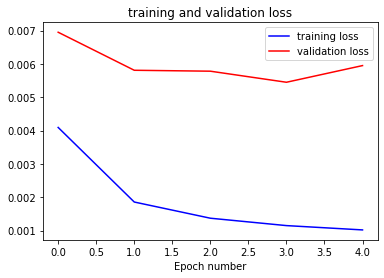

In [38]:
# Plot train and val_loss: Mean squared error
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.title('training and validation loss')
plt.legend()
plt.show()  

In [39]:
## Get model predictions:
#train_pred = model.predict(train_input)
val_pred = model.predict(val_input)
train_pred = model.predict(train_input)

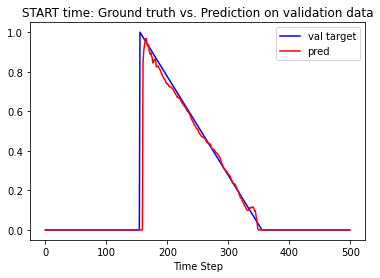

In [41]:
# small model

# Fidelity check: Plot predicted START time vs. target for on event in validation data
plt.plot(val_target[5400:5900,0], color = 'blue', label = 'val target')
plt.plot(val_pred[5400:5900,0], color = 'red', label = 'pred')
plt.xlabel('Time Step')
plt.title('START time: Ground truth vs. Prediction on validation data')
plt.legend()
plt.show()

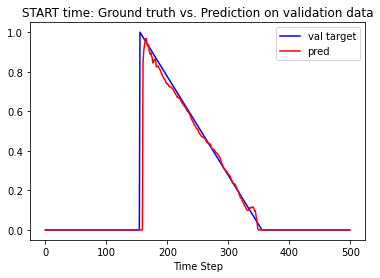

In [43]:
# small model

# Fidelity check: Plot predicted START time vs. target for on event in validation data
plt.plot(val_target[5400:5900,0], color = 'blue', label = 'val target')
plt.plot(val_pred[5400:5900,0], color = 'red', label = 'pred')
plt.xlabel('Time Step')
plt.title('START time: Ground truth vs. Prediction on validation data')
plt.legend()
plt.show()

In [ ]:
# large model

# Fidelity check: Plot predicted START time vs. target for on event in validation data
plt.plot(val_target[5400:6200,0], color = 'blue', label = 'val target')
plt.plot(val_pred[5400:6200,0], color = 'red', label = 'pred')
plt.xlabel('Time Step')
plt.title('START time: Ground truth vs. Prediction on validation data')
plt.legend()
plt.show()

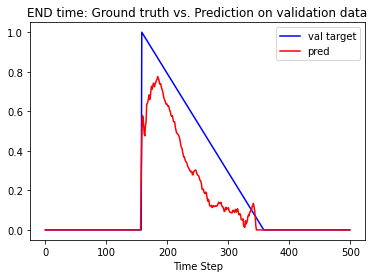

In [45]:
# small model

# Fidelity check: Plot predicted END time vs. target for on event in validation data
plt.plot(val_target[6600:7100,1], color = 'blue', label = 'val target')
plt.plot(val_pred[6600:7100,1], color = 'red', label = 'pred')
plt.xlabel('Time Step')
plt.title('END time: Ground truth vs. Prediction on validation data')
plt.legend()
plt.show()

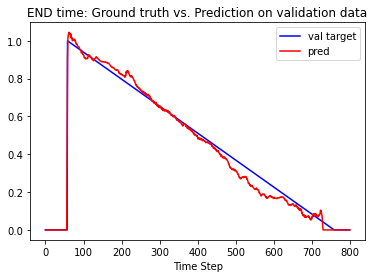

In [250]:
# large model

# Fidelity check: Plot predicted END time vs. target for on event in validation data
plt.plot(val_target[6600:7400,1], color = 'blue', label = 'val target')
plt.plot(val_pred[6600:7400,1], color = 'red', label = 'pred')
plt.xlabel('Time Step')
plt.title('END time: Ground truth vs. Prediction on validation data')
plt.legend()
plt.show()

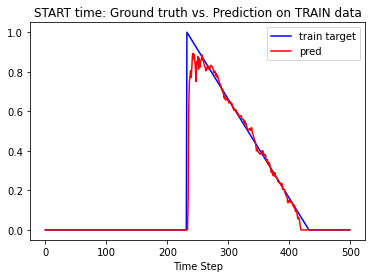

In [50]:
# small model

# Fidelity check: Plot predicted START time vs. target for on event in TRAIN data
plt.plot(train_target[41700:42200,0], color = 'blue', label = 'train target')
plt.plot(train_pred[41700:42200,0], color = 'red', label = 'pred')
plt.xlabel('Time Step')
plt.title('START time: Ground truth vs. Prediction on TRAIN data')
plt.legend()
plt.show()

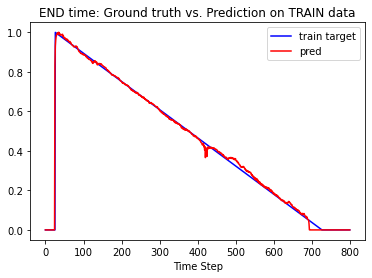

In [260]:
# large model

# Fidelity check: Plot predicted END time vs. target for on event in TRAIN data
plt.plot(train_target[42400:43200,1], color = 'blue', label = 'train target')
plt.plot(train_pred[42400:43200,1], color = 'red', label = 'pred')
plt.xlabel('Time Step')
plt.title('END time: Ground truth vs. Prediction on TRAIN data')
plt.legend()
plt.show()

In [51]:
## In our sliding window approach we have input_length overlapping samples for each time step.
## Only pick every input_length's target, to avoid overlap:
val_target_plain = val_target[np.arange(0,len(val_target),input_length)]
val_pred_plain = val_pred[np.arange(0,len(val_pred),input_length)]
train_target_plain = train_target[np.arange(0,len(train_target),input_length)]
train_pred_plain = train_pred[np.arange(0,len(train_pred),input_length)]

# Check dimensions and number of events:
print("val_target shape WITHOUT overlap: ", val_target_plain.shape)
print("val_pred shape WITHOUT overlap: ", val_pred_plain.shape)
print("val_target: number of ON switching events: ", np.sum((val_target_plain[:,0]!=0)))
print("val_target: number of OFF switching events: ", np.sum((val_target_plain[:,1]!=0)))
print("val_pred: number of ON switching events: ", np.sum((val_pred_plain[:,0]!=0)))
print("val_pred: number of OFF switching events: ", np.sum((val_pred_plain[:,1]!=0)))

print("\ntrain_target shape WITHOUT overlap: ", train_target_plain.shape)
print("train_pred shape WITHOUT overlap: ", train_pred_plain.shape)
print("train_target: number of ON switching events: ", np.sum((train_target_plain[:,0]!=0)))
print("train_target: number of OFF switching events: ", np.sum((train_target_plain[:,1]!=0)))
print("train_pred: number of ON switching events: ", np.sum((train_pred_plain[:,0]!=0)))
print("train_pred: number of OFF switching events: ", np.sum((train_pred_plain[:,1]!=0)))

val_target shape WITHOUT overlap:  (778, 2)
val_pred shape WITHOUT overlap:  (778, 2)
val_target: number of ON switching events:  30
val_target: number of OFF switching events:  31
val_pred: number of ON switching events:  35
val_pred: number of OFF switching events:  40

train_target shape WITHOUT overlap:  (3110, 2)
train_pred shape WITHOUT overlap:  (3110, 2)
train_target: number of ON switching events:  69
train_target: number of OFF switching events:  68
train_pred: number of ON switching events:  74
train_pred: number of OFF switching events:  78


In [52]:
### Restore appliance's power load from plain targets and predictions:

## First restore start and end times:

## Validation data:

# Initialize storage:
val_target_plain_start = np.zeros(len(val_target_plain) * input_length)
val_target_plain_end = np.zeros(len(val_target_plain) * input_length)
val_pred_plain_start = np.zeros(len(val_pred_plain) * input_length)
val_pred_plain_end = np.zeros(len(val_pred_plain) * input_length)

# Loop over plain target:
for i in range(len(val_target_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(val_target_plain[i,0] * input_length)
    end_time_abs = int(val_target_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        val_target_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        val_target_plain_end[(i * input_length) + end_time_abs - 1] = 1
        
        
# Loop over plain pred:
for i in range(len(val_pred_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(val_pred_plain[i,0] * input_length)
    end_time_abs = int(val_pred_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        val_pred_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        val_pred_plain_end[(i * input_length) + end_time_abs - 1] = 1

        
## Train data:

# Initialize storage:
train_target_plain_start = np.zeros(len(train_target_plain) * input_length)
train_target_plain_end = np.zeros(len(train_target_plain) * input_length)
train_pred_plain_start = np.zeros(len(train_pred_plain) * input_length)
train_pred_plain_end = np.zeros(len(train_pred_plain) * input_length)

# Loop over plain target:
for i in range(len(train_target_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(train_target_plain[i,0] * input_length)
    end_time_abs = int(train_target_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        train_target_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        train_target_plain_end[(i * input_length) + end_time_abs - 1] = 1
        
        
# Loop over plain pred:
for i in range(len(train_pred_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(train_pred_plain[i,0] * input_length)
    end_time_abs = int(train_pred_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        train_pred_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        train_pred_plain_end[(i * input_length) + end_time_abs - 1] = 1



In [53]:
### Then restore power load from restored start and end times:


## Val Target:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
val_target_plain_ON_OFF = val_target_plain_start - val_target_plain_end

# Initialize storage:
val_target_plain_load = np.zeros(len(val_target_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(val_target_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        val_target_plain_load[i] = np.max([0, val_target_plain_ON_OFF[i]])
    else:
        val_target_plain_load[i] = np.min([1, np.max([0, val_target_plain_load[i-1] + val_target_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
val_target_plain_load = val_target_plain_load * target1_mean_load


## Val Pred:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
val_pred_plain_ON_OFF = val_pred_plain_start - val_pred_plain_end

# Initialize storage:
val_pred_plain_load = np.zeros(len(val_pred_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(val_pred_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        val_pred_plain_load[i] = np.max([0, val_pred_plain_ON_OFF[i]])
    else:
        val_pred_plain_load[i] = np.min([1, np.max([0, val_pred_plain_load[i-1] + val_pred_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
val_pred_plain_load = val_pred_plain_load * target1_mean_load


## Train Target:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
train_target_plain_ON_OFF = train_target_plain_start - train_target_plain_end

# Initialize storage:
train_target_plain_load = np.zeros(len(train_target_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(train_target_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        train_target_plain_load[i] = np.max([0, train_target_plain_ON_OFF[i]])
    else:
        train_target_plain_load[i] = np.min([1, np.max([0, train_target_plain_load[i-1] + train_target_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
train_target_plain_load = train_target_plain_load * target1_mean_load


## Train Pred:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
train_pred_plain_ON_OFF = train_pred_plain_start - train_pred_plain_end

# Initialize storage:
train_pred_plain_load = np.zeros(len(train_pred_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(train_pred_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        train_pred_plain_load[i] = np.max([0, train_pred_plain_ON_OFF[i]])
    else:
        train_pred_plain_load[i] = np.min([1, np.max([0, train_pred_plain_load[i-1] + train_pred_plain_ON_OFF[i]])])

# And finally multiply load series with target1_mean_load:
train_pred_plain_load = train_pred_plain_load * target1_mean_load

Text(0, 0.5, 'Power [W]')

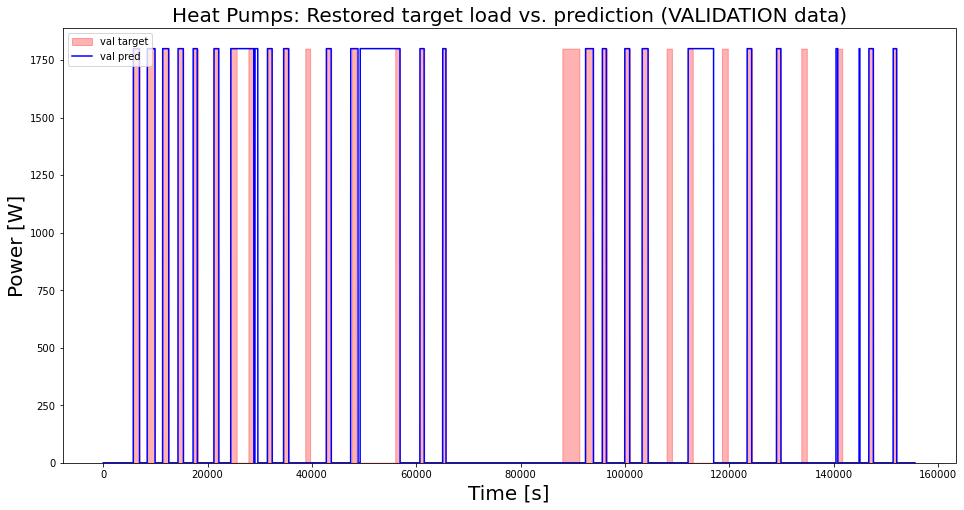

In [54]:
# small model

# Plot restored target load for heat pumps (aggregated) vs. restored prediction on VALIDATION data
# from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(len(val_target_plain_load)), val_target_plain_load, color="red", alpha=0.3, labels=['val target'])
ax.plot(val_pred_plain_load, color="blue", label='val pred')
plt.legend(loc='upper left')
plt.title('Heat Pumps: Restored target load vs. prediction (VALIDATION data)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

Text(0, 0.5, 'Power [W]')

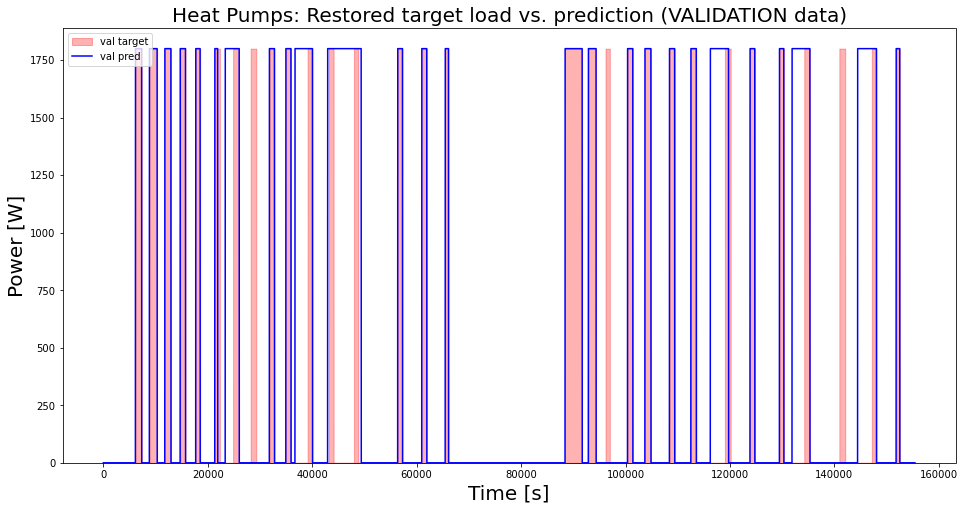

In [266]:
# large model

# Plot restored target load for heat pumps (aggregated) vs. restored prediction on VALIDATION data
# from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(len(val_target_plain_load)), val_target_plain_load, color="red", alpha=0.3, labels=['val target'])
ax.plot(val_pred_plain_load, color="blue", label='val pred')
plt.legend(loc='upper left')
plt.title('Heat Pumps: Restored target load vs. prediction (VALIDATION data)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

Text(0, 0.5, 'Power [W]')

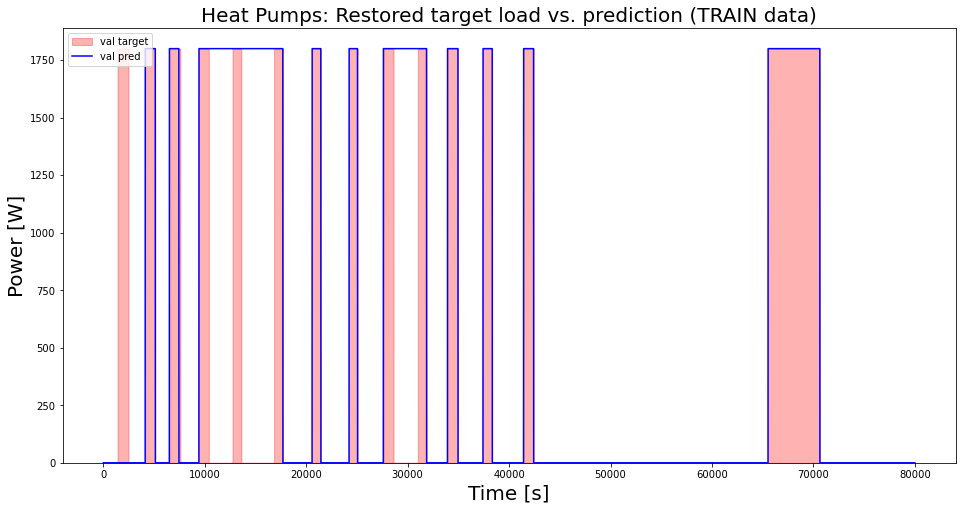

In [55]:
# small model

# Plot restored target load for heat pumps (aggregated) vs. restored prediction on TRAIN data
# from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(len(train_target_plain_load[38000:118000])), train_target_plain_load[38000:118000], color="red", alpha=0.3, labels=['val target'])
ax.plot(train_pred_plain_load[38000:118000], color="blue", label='val pred')
plt.legend(loc='upper left')
plt.title('Heat Pumps: Restored target load vs. prediction (TRAIN data)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

Text(0, 0.5, 'Power [W]')

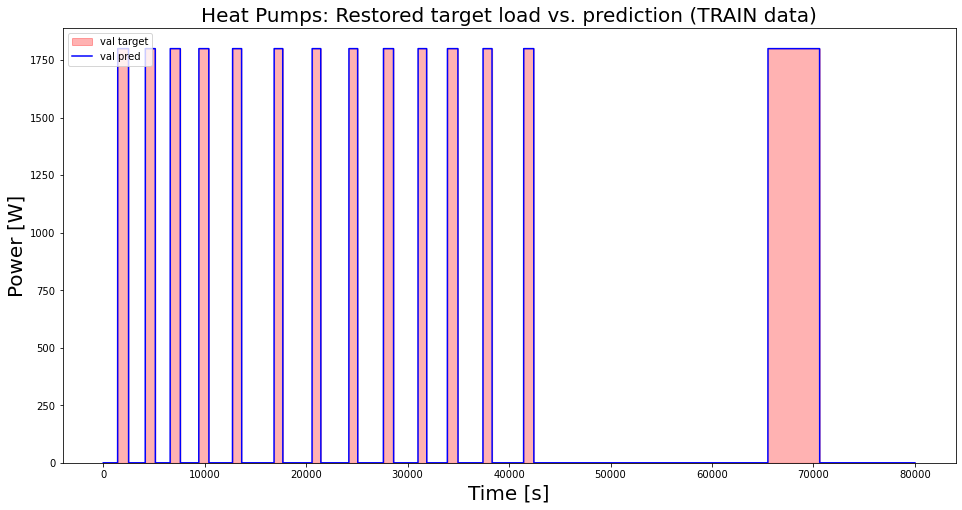

In [267]:
# large model

# Plot restored target load for heat pumps (aggregated) vs. restored prediction on TRAIN data
# from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(len(train_target_plain_load[38000:118000])), train_target_plain_load[38000:118000], color="red", alpha=0.3, labels=['val target'])
ax.plot(train_pred_plain_load[38000:118000], color="blue", label='val pred')
plt.legend(loc='upper left')
plt.title('Heat Pumps: Restored target load vs. prediction (TRAIN data)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

### Model Evaluation

[Marwah and Han, 2011] describe **Precision, Recall and F-measure** as some metrics used for evaluation of our models' performance: Let $x$ be the predicted value and $x_0$ to be the ground truth. In our case we look at power consumption of a certain appliance at a certain time step. We then need to distinguish:

$$
x=0\,\,\,AND\,\,\,x_0=0\,\,\,\,\,\,\rightarrow TN \\
x=0\,\,\,AND\,\,\,x_0>0\,\,\,\,\,\,\rightarrow FN \\
x>0\,\,\,AND\,\,\,x_0=0\,\,\,\,\,\,\rightarrow FP \\
x>0\,\,\,AND\,\,\,x_0>0\,\,\,\,\,\,\rightarrow TP 
$$

Here TN, FN, FP and TP refer to "true negative", "false negative", "false positive" and "true positive", respectively. TP is then further split into "inaccurate true positive" (ITP) and "accurate true positive" (ATP), given $\frac{|x-x_0|}{x_0}>\rho$ or $\frac{|x-x_0|}{x_0}\leq\rho$, respectively, with some threshhold $\rho=0.2$.

We then define **Precision**=$\frac{ATP}{ATP + ITP + FP}$, **Recall**=$\frac{ATP}{ATP + ITP + FN}$ and **F-measure**=$\frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$.

In [56]:
# small model

# Define measures on VALIDATION data:
val_TN = sum((val_pred_plain_load == 0) & (val_target_plain_load == 0))
val_FN = sum((val_pred_plain_load == 0) & (val_target_plain_load > 0))
val_FP = sum((val_pred_plain_load > 0) & (val_target_plain_load == 0))
val_TP = sum((val_pred_plain_load > 0) & (val_target_plain_load > 0))
val_prec = val_TP / (val_TP + val_FP)
val_rec = val_TP / (val_TP + val_FN)
val_Fmeas = (2 * val_prec * val_rec) / (val_prec + val_rec)

# Define measures on TRAIN data:
train_TN = sum((train_pred_plain_load == 0) & (train_target_plain_load == 0))
train_FN = sum((train_pred_plain_load == 0) & (train_target_plain_load > 0))
train_FP = sum((train_pred_plain_load > 0) & (train_target_plain_load == 0))
train_TP = sum((train_pred_plain_load > 0) & (train_target_plain_load > 0))
train_prec = train_TP / (train_TP + train_FP)
train_rec = train_TP / (train_TP + train_FN)
train_Fmeas = (2 * train_prec * train_rec) / (train_prec + train_rec)

# Check measures:
print("train precision: ", np.round(train_prec * 100,1), "%")
print("train recall: ", np.round(train_rec * 100,1), "%")
print("train F-measure: ", np.round(train_Fmeas * 100,1), "%")
print("\nval precision: ", np.round(val_prec * 100,1), "%")
print("val recall: ", np.round(val_rec * 100,1), "%")
print("val F-measure: ", np.round(val_Fmeas * 100,1), "%")

train precision:  66.0 %
train recall:  92.7 %
train F-measure:  77.1 %

val precision:  61.0 %
val recall:  71.7 %
val F-measure:  65.9 %


In [268]:
# large model

# Define measures on VALIDATION data:
val_TN = sum((val_pred_plain_load == 0) & (val_target_plain_load == 0))
val_FN = sum((val_pred_plain_load == 0) & (val_target_plain_load > 0))
val_FP = sum((val_pred_plain_load > 0) & (val_target_plain_load == 0))
val_TP = sum((val_pred_plain_load > 0) & (val_target_plain_load > 0))
val_prec = val_TP / (val_TP + val_FP)
val_rec = val_TP / (val_TP + val_FN)
val_Fmeas = (2 * val_prec * val_rec) / (val_prec + val_rec)

# Define measures on TRAIN data:
train_TN = sum((train_pred_plain_load == 0) & (train_target_plain_load == 0))
train_FN = sum((train_pred_plain_load == 0) & (train_target_plain_load > 0))
train_FP = sum((train_pred_plain_load > 0) & (train_target_plain_load == 0))
train_TP = sum((train_pred_plain_load > 0) & (train_target_plain_load > 0))
train_prec = train_TP / (train_TP + train_FP)
train_rec = train_TP / (train_TP + train_FN)
train_Fmeas = (2 * train_prec * train_rec) / (train_prec + train_rec)

# Check measures:
print("train precision: ", np.round(train_prec * 100,1), "%")
print("train recall: ", np.round(train_rec * 100,1), "%")
print("train F-measure: ", np.round(train_Fmeas * 100,1), "%")
print("\nval precision: ", np.round(val_prec * 100,1), "%")
print("val recall: ", np.round(val_rec * 100,1), "%")
print("val F-measure: ", np.round(val_Fmeas * 100,1), "%")

train precision:  99.1 %
train recall:  88.8 %
train F-measure:  93.6 %

val precision:  62.3 %
val recall:  87.3 %
val F-measure:  72.7 %
